# Finding ICU Bed Capacity
Current reporting of ICU bed capacity isn't necessarily reliable or accurate. May be able to capture the capacity by looking at how the death rate and case rate compare. A spike in deaths may mean above capacity.

In [113]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates
from src.utils.preprocessing import moving_average

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()
infections, infections_date = load_infection_time_series()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

Mobility Last Updated 05-08
Deaths Last Updated 05-08


In [115]:
death_dates = get_date_columns(deaths, return_dtimes=False)
infection_dates = get_date_columns(infections, return_dtimes=False)

In [44]:
counties[counties['Area_Name']=='King County']

,FIPS,State,Area_Name,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2018,N_POP_CHG_2018,Births_2018,Deaths_2018,...,Total number of UCR (Uniform Crime Report) Index crimes excluding arson.,Total number of UCR (Uniform Crime Report) index crimes reported including arson,MURDER,RAPE,ROBBERY,Number of AGGRAVATED ASSAULTS,BURGLRY,LARCENY,MOTOR VEHICLE THEFTS,ARSON
2702,48269,TX,King County,9.0,12.0,1.0,277,-12.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3018,53033,WA,King County,1.0,1.0,0.0,2233163,28934.0,26097.0,13730.0,...,6894.0,80366.0,57.0,574.0,2572.0,3691.0,17559.0,53262.0,9545.0,310.0


In [45]:
FIPS = 53033

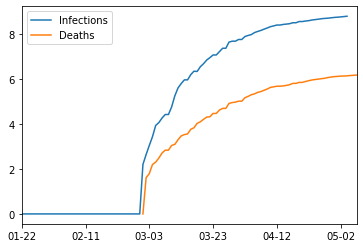

In [116]:
ax = infections[infections['FIPS'] == FIPS][infection_dates].transform('log').T.plot()
deaths[deaths['FIPS'] == FIPS][death_dates].transform('log').T.plot(ax=ax)
ax.legend(['Infections', 'Deaths'])

In [117]:
ma_deaths = moving_average(deaths[deaths['FIPS'] == FIPS][death_dates], death_dates, 3)
ma_infections = moving_average(infections[infections['FIPS'] == FIPS][infection_dates], infection_dates, 3)

In [118]:
np_deaths = ma_deaths.values[0]
np_infections = ma_infections.values[0]

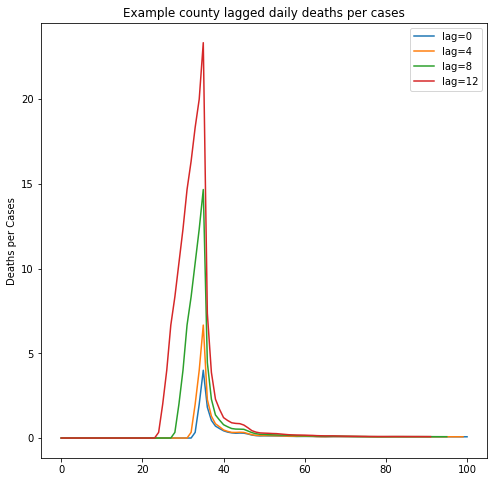

In [132]:
plt.figure(figsize=(8,8))
for i in range(0,13,4):
    ds = np_deaths[max(i,3):]
    plt.plot(ds / np_infections[:len(ds)] , label=f'lag={i}')

plt.legend()
plt.title('Example county lagged daily deaths per cases')
plt.ylabel('Deaths per Cases')
plt.show()

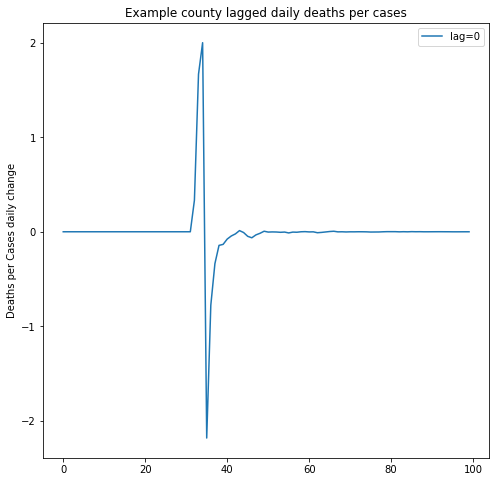

In [134]:
plt.figure(figsize=(8,8))
for i in [0]:#range(0,13,4):
    ds = np_deaths[max(i,3):]
    plt.plot(np.diff(ds / np_infections[:len(ds)], n=1), label=f'lag={i}')

plt.legend()
plt.title('Example county lagged daily deaths per cases')
plt.ylabel('Deaths per Cases daily change')
plt.show()